## Loading pre-trained model
https://github.com/caffe2/tutorials/blob/master/Loading_Pretrained_Models.ipynb

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import os
from caffe2.python import core, workspace, models
import urllib.request
import operator
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')
# print(font)
print("Required modules imported.")


Required modules imported.


## download models
https://s3.amazonaws.com/download.caffe2.ai/models/squeezenet/predict_net.pb<br>
https://s3.amazonaws.com/download.caffe2.ai/models/squeezenet/init_net.pb

In [12]:
CAFFE_MODELS = "./models"

# Some sample images you can try, or use any URL to a regular image.
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Whole-Lemon.jpg/1235px-Whole-Lemon.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/7/7b/Orange-Whole-%26-Split.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/a/ac/Pretzel.jpg"
# IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"

IMAGE_LOCATION = "./images/flower.jpg"
MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print("Config set!")

Config set!


In [13]:
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    print("No mean file found!")
    mean = 128
else:
    print("Mean file found!")
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: {}".format(mean))

INPUT_IMAGE_SIZE = MODEL[4]

INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])
if not os.path.exists(INIT_NET):
    print("WARNING: " + INIT_NET + "not found!")
else:
    if not os.path.exists(PREDICT_NET):
        print("WARNING: " + PREDICT_NET + "not found!")
    else:
        print("All needed files found!")

No mean file found!
mean was set to: 128
All needed files found!


Original Image Shape: (751, 1280, 3)
Image shape after rescaling: (227, 386, 3)


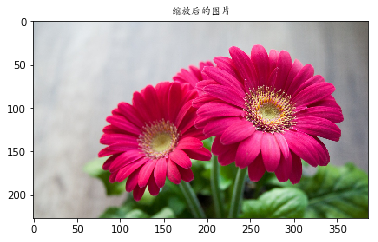

Image shape after cropping: (227, 227, 3)


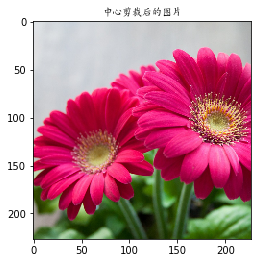

CHW Image Shape: (3, 227, 227)
<class 'numpy.ndarray'>
NCHW image: (1, 3, 227, 227)


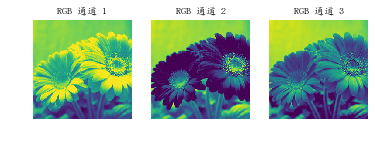

In [84]:
def crop_center(img, cropx, cropy):
    y, x, c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx: startx+cropx]
def rescale(img, input_height, input_width):
    aspect = img.shape[1]/float(img.shape[0])
    if(aspect>1):
        res = int(aspect*input_height)
        img_scaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        res = int(input_width/aspect)
        img_scaled = skimage.transform.resize(img, (res, input_height))
    if(aspect==1):
        img_scaled = skimage.transform.resize(img, (input_widht, input_height))
    return img_scaled
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
print("Original Image Shape: {}".format(img.shape))
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image shape after rescaling: {}".format(img.shape))
plt.figure()
plt.imshow(img)
plt.title("缩放后的图片", fontproperties=font)
plt.savefig("./images/scaled.png", format='png')
plt.show()

img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image shape after cropping: {}".format(img.shape))
plt.figure()
plt.imshow(img)
plt.title("中心剪裁后的图片", fontproperties=font)
plt.savefig("./images/crop_center.png", format="png")
plt.show()

# switch to CHW(HWC->CHW)
img = img.swapaxes(1, 2).swapaxes(0, 1)
print("CHW Image Shape: {}".format(img.shape))

plt.figure()
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img[i])
    plt.axis("off")
    plt.title("RGB 通道 {}".format(i+1), fontproperties=font)
plt.savefig("./images/channels.png", format="png")
print(type(img))
# switch to BGR(RGB->BGR)
img = img[(2, 1, 0), :, :]

img = img * 225 - mean

img = img[np.newaxis, :, :, :].astype(np.float32)
print("NCHW image: {}".format(img.shape))


## prepare CNN and run the net

In [77]:
with open(INIT_NET, "rb") as f:
    init_net = f.read()
with open(PREDICT_NET, "rb") as f:
    predict_net = f.read()

p = workspace.Predictor(init_net, predict_net)
results = p.run({"data": img})
results = np.asarray(results)
print("results shape: {}".format(results.shape))
preds = np.squeeze(results)
curr_pred, curr_conf = max(enumerate(preds), key=operator.itemgetter(1))
print("Prediction: {}".format(curr_pred))
print("Confidence: {}".format(curr_conf))

results shape: (1, 1, 1000, 1, 1)
Prediction: 985
Confidence: 0.9754712581634521


In [78]:
import json
results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0, 2), dtype=object)
arr[:, 0] = int(10)
arr[:, 1:] = float(10)
for i, r in enumerate(results):
    i = i + 1
    arr = np.append(arr, np.array([[i, r]]), axis=0)
    if(r>highest):
        highest = r
        index = i
N = 5
topN = sorted(arr, key=lambda x: x[1], reverse=True)[:N]
print("Raw top {} results {}".format(N, topN))
topN_inds = [int(x[0]) for x in topN]
print("Top {} classes in order: {}".format(N, topN_inds))

json_data = "./datas/labels.json"

def save_label(codes, json_data):
    response = urllib.request.urlopen(codes)
    print("response: {}".format(response))
    response = response.read().decode('utf-8')
    response = eval(response)

    '''
    {
     0: 'tench, Tinca tinca',
     1: 'goldfish, Carassius auratus',
     2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
     3: 'tiger shark, Galeocerdo cuvieri',
     4: 'hammerhead, hammerhead shark',}
    '''
    # print("response: {}".format(response))
    print("type of response: {}".format(type(response)))
    
    # save label in file
    with open(json_data, 'w', encoding='utf-8') as f:
        json.dump(response, f, ensure_ascii=False)
# save url data to json file, later use directly.
save_label(codes, json_data)
# read label from file
with open(json_data, "r") as f:
    labels = f.readlines()
# extract string from list
labels = labels[0]
# swicth str to dict
labels = eval(labels)
# print("labels: {}".format(type(data[0])))
# print("labels: {}".format(data))
# print("eval label: {}".format(eval(data[0])))
class_LUT = []
for k,v in labels.items():
    v = v.split(",")[0]
#     print("label: {}".format(v))
    class_LUT.append(v)

for n in topN:
    print("Model predicts '{}' with {} confidence".format(class_LUT[int(n[0])], float("{0:.2f}".format(n[1]*100))))

Raw top 5 results [array([985.0, 0.9754712581634521], dtype=object), array([309.0, 0.016970906406641006], dtype=object), array([946.0, 0.005790581461042166], dtype=object), array([325.0, 0.0006192047731019557], dtype=object), array([944.0, 0.0003482984029687941], dtype=object)]
Top 5 classes in order: [985, 309, 946, 325, 944]
Model predicts 'daisy' with 97.55 confidence
Model predicts 'bee' with 1.7 confidence
Model predicts 'cardoon' with 0.58 confidence
Model predicts 'sulphur butterfly' with 0.06 confidence
Model predicts 'artichoke' with 0.03 confidence


In [80]:
images = ["./images/cowboy-hat.jpg","./images/cell-tower.jpg", "./images/Ducreux.jpg",
         "./images/pretzel.jpg", "./images/orangutan.jpg", "./images/aircraft-carrier.jpg",
         "./images/cat.jpg"]
NCHW_batch = np.zeros((len(images), 3, 227, 227))
print("Batch Shape: {}".format(NCHW_batch.shape))
for i, curr_img in enumerate(images):
    img = skimage.img_as_float(skimage.io.imread(curr_img)).astype(np.float32)
    img = rescale(img, 227, 227)
    img = crop_center(img, 227, 227)
    img = img.swapaxes(1, 2).swapaxes(0, 1)
    img = img[(2, 1, 0), :, :]
    img = img * 225 - mean
    NCHW_batch[i] = img
print("NCHW image: {}".format(NCHW_batch.shape))
results = p.run([NCHW_batch.astype(np.float32)])
results = np.asarray(results)
preds = np.squeeze(results)

print("Squeezed Predictions Shape, with batch size {}:{}".format(len(images), preds.shape))
for i, pred in enumerate(preds):
    print("Results for: {}".format(images[i]))
    curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
    print("\t Prediction: {}".format(curr_pred))
    print("\t Class Name: {}".format(class_LUT[int(curr_pred)]))
    print("\t Confidence: {}".format(curr_conf))

Batch Shape: (7, 3, 227, 227)
NCHW image: (7, 3, 227, 227)
Squeezed Predictions Shape, with batch size 7:(7, 1000)
Results for: ./images/cowboy-hat.jpg
	 Prediction: 515
	 Class Name: cowboy hat
	 Confidence: 0.8236430287361145
Results for: ./images/cell-tower.jpg
	 Prediction: 755
	 Class Name: radio telescope
	 Confidence: 0.8589521050453186
Results for: ./images/Ducreux.jpg
	 Prediction: 215
	 Class Name: Brittany spaniel
	 Confidence: 0.05261107534170151
Results for: ./images/pretzel.jpg
	 Prediction: 932
	 Class Name: pretzel
	 Confidence: 0.9999996423721313
Results for: ./images/orangutan.jpg
	 Prediction: 365
	 Class Name: orangutan
	 Confidence: 0.964085042476654
Results for: ./images/aircraft-carrier.jpg
	 Prediction: 403
	 Class Name: aircraft carrier
	 Confidence: 0.8615673184394836
Results for: ./images/cat.jpg
	 Prediction: 282
	 Class Name: tiger cat
	 Confidence: 0.44642215967178345


In [58]:
dict_data = {0:"afjad,ajfdkajfd"}
print("dict: {}".format(dict_data[0]))
data = dict_data[0]
print("type: {}".format(type(data)))
data = data.split(",")
print(data)

dict: afjad,ajfdkajfd
type: <class 'str'>
['afjad', 'ajfdkajfd']
